# There are multiple models here

In [5]:
import sys
!{sys.executable} -m pip install imbalanced-learn

  Obtaining dependency information for imbalanced-learn from https://files.pythonhosted.org/packages/a3/9e/fbe60a768502af54563dcb59ca7856f5a8833b3ad5ada658922e1ab09b7f/imbalanced_learn-0.11.0-py3-none-any.whl.metadata
  Obtaining dependency information for joblib>=1.1.1 from https://files.pythonhosted.org/packages/10/40/d551139c85db202f1f384ba8bcf96aca2f329440a844f924c8a0040b6d02/joblib-1.3.2-py3-none-any.whl.metadata
   ---------------------------------------- 235.6/235.6 kB 7.3 MB/s eta 0:00:00
   --------------------------------------- 302.2/302.2 kB 18.2 MB/s eta 0:00:00
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0



[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: E:\Python\python.exe -m pip install --upgrade pip


In [24]:
import pandas as pd
import numpy as np
import pickle
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

## emoji generator model

In [7]:
df = pd.read_csv('emoji.csv')
df.head()

,original_message,lisas_reply,reply_text,reply_emojis
0,imagine not having nitro lisa,:lisacat:,NaN,:lisacat:
1,make everyone admin,should i @brioche 🦑 @arin 🐢,should i @brioche 🦑 @arin 🐢,NaN
2,take photo of food,Don’t take a photo of food,Don’t take a photo of food,NaN
3,you are mean,:ken:,NaN,:ken:
4,No,that’s a bit mean,that’s a bit mean,NaN


In [26]:
df = pd.read_csv('emoji-syn.csv')
df.head()
print(df.columns)

ERROR! Session/line number was not unique in database. History logging moved to new session 102
Index(['original_message', 'lisas_reply', 'reply_text', 'reply_emojis',
       'synthetics '],
      dtype='object')


In [27]:
#only run if using synthetic data
df['combined'] = df['reply_emojis'].combine_first(df['synthetics '])

print(df.columns)

Index(['original_message', 'lisas_reply', 'reply_text', 'reply_emojis',
       'synthetics ', 'combined'],
      dtype='object')


In [28]:
#only run if using synthetic data
df = df.dropna(subset=['combined'])
print(df.columns)
print(f"rows: {len(df)}")

df.drop(['lisas_reply','reply_text', 'synthetics ', 'reply_emojis'], axis=1, inplace=True)
df = df.rename(columns={'combined': 'reply_emojis'})

df.head()

Index(['original_message', 'lisas_reply', 'reply_text', 'reply_emojis',
       'synthetics ', 'combined'],
      dtype='object')
rows: 1039


,original_message,reply_emojis
0,imagine not having nitro lisa,:lisaCat:
1,make everyone admin,:heheHarrison:
2,take photo of food,:catCry:
3,you are mean,:ken:
4,No,:mad:


In [58]:
df = df.dropna(subset=['reply_emojis'])
df.drop(['lisas_reply','reply_text'], axis=1, inplace=True)

print(df.columns)
df.head()

KeyError: "['lisas_reply', 'reply_text'] not found in axis"

In [11]:
print(f"rows: {len(df)}")

rows: 846


In [29]:
# Encoding the string column to numeric values
df['encoded'] = pd.factorize(df['reply_emojis'])[0]

print(df)

                                       original_message         reply_emojis  \
0                         imagine not having nitro lisa            :lisaCat:   
1                                   make everyone admin       :heheHarrison:   
2                                    take photo of food             :catCry:   
3                                          you are mean                :ken:   
4                                                    No                :mad:   
...                                                 ...                  ...   
4265        Are there any homeware stores in Newmarket?           :pigWoozy:   
4266  ||@bozo ||\n\nReact to the days that you are c...            :skull~1:   
4272                                Cricket every night  :erinnnnnnnnnnnnnn:   
4286                                             right?           :thinking:   
4304  @pizza 💅🏻 @ae2 crip🦕 best bday present for you...           :thinking:   

      encoded  
0           0  
1      

In [9]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(df['reply_emojis'])

In [30]:
emoji_encoded = df['encoded'].tolist()
print(emoji_encoded)

[0, 1, 2, 3, 4, 3, 0, 5, 2, 6, 6, 7, 8, 8, 9, 10, 2, 10, 0, 11, 7, 12, 0, 13, 14, 15, 13, 4, 15, 5, 13, 16, 17, 0, 4, 14, 18, 13, 7, 2, 2, 0, 16, 2, 0, 19, 20, 21, 0, 16, 10, 22, 23, 2, 0, 20, 21, 2, 4, 9, 0, 0, 0, 16, 14, 23, 22, 16, 4, 21, 21, 23, 8, 21, 21, 24, 0, 20, 25, 5, 13, 21, 10, 2, 21, 26, 2, 0, 2, 0, 2, 17, 26, 2, 19, 2, 2, 17, 17, 26, 21, 0, 5, 4, 26, 2, 27, 21, 8, 28, 29, 10, 21, 23, 14, 23, 0, 25, 30, 23, 23, 0, 7, 21, 27, 0, 27, 28, 25, 4, 7, 0, 4, 20, 2, 23, 4, 29, 4, 28, 13, 15, 24, 9, 3, 13, 2, 22, 15, 15, 2, 3, 14, 2, 28, 28, 31, 23, 28, 25, 8, 32, 25, 25, 3, 3, 3, 17, 17, 3, 31, 10, 9, 28, 6, 0, 20, 31, 15, 31, 25, 25, 16, 0, 30, 24, 26, 23, 0, 23, 16, 14, 28, 28, 16, 26, 8, 16, 21, 23, 6, 27, 18, 23, 27, 1, 0, 23, 0, 14, 25, 0, 16, 33, 34, 34, 24, 0, 28, 0, 26, 29, 22, 4, 8, 3, 21, 35, 27, 0, 36, 0, 25, 36, 0, 16, 37, 21, 15, 23, 21, 5, 38, 3, 4, 9, 10, 21, 5, 14, 31, 0, 9, 21, 27, 21, 31, 31, 31, 31, 21, 24, 31, 31, 5, 23, 31, 9, 9, 9, 39, 9, 9, 21, 4, 31, 34, 23

In [31]:
emojis = pd.factorize(df['reply_emojis'])[1]

encoded_to_string = {i: string for i, string in enumerate(emojis)}
def get_emoji_back(encoded_number):
    return encoded_to_string.get(encoded_number, "Unknown")

print(get_emoji_back(7))

:pigShock:


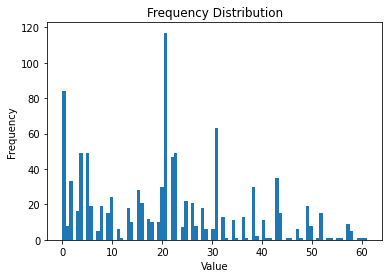

In [32]:
import matplotlib.pyplot as plt

plt.hist(emoji_encoded, bins=90)  # 'bins' can be an integer or 'auto' for automatic bin sizing
plt.title('Frequency Distribution')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [33]:
import pandas as pd
from collections import Counter

# Assuming 'emoji_encoded' is your list/array of encoded emojis
emoji_frequencies = Counter(emoji_encoded)

# Convert to a list of (emoji, frequency) pairs
emoji_freq_list = list(emoji_frequencies.items())

# Create a DataFrame with the emoji and their frequencies
emoji_freq_df = pd.DataFrame(emoji_freq_list, columns=['Emoji', 'Frequency'])

# Sort the DataFrame by frequency in descending order
emoji_freq_df = emoji_freq_df.sort_values('Frequency', ascending=False).reset_index(drop=True)

# Map the encoded numbers to their string representations
emoji_freq_df['Emoji_Char'] = emoji_freq_df['Emoji'].map(encoded_to_string)

# Display the DataFrame
print(emoji_freq_df)

emoji_freq_df.to_csv('emoji_freq_df.csv', index=False)

    Emoji  Frequency                                         Emoji_Char
0      21        117                                :erinnnnnnnnnnnnnn:
1       0         84                                          :lisaCat:
2      31         63                                             no you
3       5         49                                          :skull~1:
4      23         49  https://cdn.discordapp.com/emojis/841886073519...
..    ...        ...                                                ...
57     41          1                                :RewardBox_Tier_01:
58     37          1                                         :blakeeee:
59     35          1                                  :Buttercup_Happy:
60     33          1                                           :pepeds:
61     61          1                                         :notSlayy:

[62 rows x 3 columns]


In [34]:
frequency = Counter(emoji_encoded)

# Find the most common encoded value
most_common_encoded_value, count = frequency.most_common(1)[0]

print(f"The most common encoded value is {most_common_encoded_value} with a count of {count}")

The most common encoded value is 21 with a count of 117


In [35]:
X = df['original_message']

# Count Vectorise
vectorizer = CountVectorizer()
X_counts = vectorizer.fit_transform(X)

# TFIDF Convert
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)

In [36]:
# Split into training and test splits (80/20)
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, emoji_encoded, test_size=0.2, random_state=0)

In [ ]:
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Define the parameter grid
param_grid = {
    'class_weight': [None, 'balanced'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_features': [None, 'sqrt', 'log2']
}

# Initialize the classifier
dt = DecisionTreeClassifier()

# Create a scorer for F1 score
f1_scorer = make_scorer(f1_score, average='macro')  # You can change 'macro' to 'micro' or 'weighted' based on your needs

# Initialize GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, scoring=f1_scorer, cv=5)

# Fit grid search
grid_search.fit(X_train, y_train)

# Find the best parameters and the corresponding F1-score
best_params = grid_search.best_params_
best_f1_score = grid_search.best_score_

print("Best parameters:", best_params)
print("Best F1-score:", best_f1_score)

E:\Python\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


In [63]:
smote = SMOTE(random_state=42)

dt_classifier = DecisionTreeClassifier(
    class_weight='balanced',
    splitter='random',
    max_features='sqrt'  
)
dt_classifier.fit(X_train, y_train)
dt_y_pred = dt_classifier.predict(X_test)

In [64]:
print(accuracy_score(y_test, dt_y_pred))
print(classification_report(y_test, dt_y_pred, zero_division=0))

0.14423076923076922
              precision    recall  f1-score   support

           0       0.09      0.08      0.09        12
           1       0.75      0.60      0.67         5
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         2
           4       0.08      0.08      0.08        12
           5       0.00      0.00      0.00         9
           6       0.25      0.33      0.29         3
           7       0.02      1.00      0.03         1
           8       0.00      0.00      0.00         6
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00         5
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         1
          15       0.10      0.17      0.12         6
          16       0.00      0.00      0.00         2
          17       1.00      0.50      0.67         2
          18       0.00      0.00      0.00         2
       

In [58]:
# GaussianNB
gnb = MultinomialNB()
gnb.fit(X_train, y_train)
gnb_pred = gnb.predict(X_test)

In [40]:
# Results
print("Confusion Matrix: ")
print(confusion_matrix(y_test,gnb_pred))

print("\nClassification Report:")
print(classification_report(y_test,gnb_pred, zero_division=0))

print("Accuracy score of our model with svm:", accuracy_score(y_test, gnb_pred))

Confusion Matrix: 
[[3 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.07      0.25      0.11        12
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00        12
           5       0.00      0.00      0.00         9
           6       0.00      0.00      0.00         3
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         6
           9       0.00      0.00      0.00         3
          10       0.00      0.00      0.00         5
          13       0.00      0.00      0.00         3
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         6
          16       0.00   

In [71]:
#function for outputting the most likely emoji
def predict_emoji(text, classifier, vectorizer):
    # Preprocess and vectorize the input text
    text_vectorized = vectorizer.transform([text])
    
    # Predict the emoji
    emoji_index = classifier.predict(text_vectorized)

    # Decode the emoji
    emoji = get_emoji_back(emoji_index[0])
    
    return emoji

text = "They didn’t want to sleep over"
predict_emoji(text, dt_classifier, vectorizer)

':yesPingu:'

In [77]:
#function for outputting any emoji as long as its probability is beyond the threshold. 
def predict_emoji(text, classifier, vectorizer, threshold=0.1):
    # Preprocess and vectorize the input text
    text_vectorized = vectorizer.transform([text])
    
    # Get probabilities for each emoji
    probabilities = classifier.predict_proba(text_vectorized)[0]

    # Filter out predictions with probabilities above the threshold
    high_prob_indices = [i for i, prob in enumerate(probabilities) if prob > threshold]

    # Decode the emojis
    emojis = [get_emoji_back(index) for index in high_prob_indices]
    
    return emojis

text = "I SPILT MY WJOLE GLASS OF WATER ON THE FALL"
predict_emoji(text, dt_classifier, vectorizer, threshold=0.1)

[':ken:']

## now lets export the model 

In [74]:
print("Encoded to String Mapping:", encoded_to_string)

Encoded to String Mapping: {0: ':lisaCat:', 1: ':heheHarrison:', 2: ':catCry:', 3: ':ken:', 4: ':mad:', 5: ':skull~1:', 6: ':joever:', 7: ':pigShock:', 8: 'https://cdn.discordapp.com/emojis/1070869015343411210.webp?size=128&quality=lossless', 9: ':clown~1:', 10: 'https://cdn.discordapp.com/emojis/1069084325720637500.webp?size=128&quality=lossless', 11: ':slayy:', 12: ':hmm:', 13: 'https://cdn.discordapp.com/emojis/881182531536449587.gif?size=128&quality=lossless', 14: 'https://cdn.discordapp.com/emojis/750768558975484065.webp?size=128&quality=lossless', 15: ':ohHello:', 16: ':catcry:', 17: ':gun:', 18: 'https://cdn.discordapp.com/emojis/954378740958363748.webp?size=128&quality=lossless', 19: ':angy:', 20: ':nathanielScary:', 21: ':erinnnnnnnnnnnnnn:', 22: ':yay:', 23: 'https://cdn.discordapp.com/emojis/841886073519996979.gif?size=128&quality=lossless', 24: ':pigCold:', 25: ':harrybarbie:', 26: ':pigWoozy:', 27: 'https://cdn.discordapp.com/emojis/1089829892616618025.webp?size=128&qualit

In [75]:
# Serialize the classifier
with open('classifier.pkl', 'wb') as file:
    pickle.dump(dt_classifier, file)

# Serialize the vectorizer
with open('vectorizer.pkl', 'wb') as file:
    pickle.dump(vectorizer, file)

# Serialize the encoded_to_string dictionary
with open('encoded_to_string.pkl', 'wb') as file:
    pickle.dump(encoded_to_string, file)

In [76]:
# load it back up
def load_pickle(file_name):
    with open(file_name, 'rb') as file:
        return pickle.load(file)

# Loading the serialized components
classifier = load_pickle('classifier.pkl')
vectorizer = load_pickle('vectorizer.pkl')
encoded_to_string = load_pickle('encoded_to_string.pkl')

# Your get_emoji_back function here
def get_emoji_back(encoded_number):
    return encoded_to_string.get(encoded_number, "Unknown")